In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import subprocess
import os
from os import path
from datetime import datetime
from matplotlib.ticker import FixedLocator

### Same prompt in taxon_abundance and biovolume notebooks
### These next 2 cells prompt the user for manual or automated taxonomic annotation input, then type of functional group analysis

In [2]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: automated


In [35]:
# Prompt user for type of analsyis
while (True):
    options = ["Bacillariophyceae", "Dinoflagellata", "Haptophyta",
               "other than diatoms, dinoflagellates, or haptophytes", "All", "All but other"]
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    analysis_type = int(input("Please enter a number (1-6) for the type analysis: "))
    if (analysis_type in range(1,7)):
        analysis_type = str(options[analysis_type-1])
        break
    print("Invalid argument")

1: Bacillariophyceae
2: Dinoflagellata
3: Haptophyta
4: other than diatoms, dinoflagellates, or haptophytes
5: All
6: All but other
Please enter a number (1-6) for the type analysis: 1


In [36]:
# # Ask user if running analysis on a new cruise
# while (True):
#     reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
#     if reply[0] == 'y':
#         break
#     if reply[0] == 'n':
#         break
#     else:
#         print("Please enter y/n")

In [37]:
# # first call bash script to get necessary file inputs
# # for geographic script, choose query_samples for underway gps data alignment as input script
# # for worms script, choose names_ids.csv for input script
# # only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
# if ( not reply[0] != 'y'):
#     subprocess.call(['./exec.sh', reply[0]])

### The following cell selects the required column headers from the level 1b summary file depending on the dataset type selected

In [38]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'higherClassification_group', 'scientificName_HumanObservation',
               'Biovolume', 'maxFeretDiameter']
elif (dataset_type == 'automated'):
    columns = ['associatedMedia', 'data_provider_category_MachineObservation', 'maxFeretDiameter',
              'minFeretDiameter', 'Area', 'Biovolume']
else:
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'data_provider_category_MachineObservation', 'higherClassification_group', 
               'scientificName_HumanObservation','Biovolume', 'maxFeretDiameter']

In [39]:
# read in level 1_b file
sample_subset = pd.read_csv('../auto_join/level_1b.csv', usecols=columns)

### User prompts to direct for 1) using a lower limit (>) or an upper limit (<) for size fractioning; 2) what type of size parameter to analyze; and 3) the threshold value

In [40]:
## prompt user to ask for above/below the threshold
while (True):
    options = ['Max threshold: <', 'Min threshold: >']
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    sign = int(input("Please enter a number (1 or 2) to choose comparison operator: "))
    if (sign in range(1,3)):
        break
    print("Invalid argument")
print('\n')

## prompt user to ask for which size parameter to analyze
while (True):
    options = ['maxFeretDiameter', 'minFeretDiameter', 'Area', 'Biovolume']
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    param = int(input("Please enter a number (1-4) for the type analysis: "))
    if (param in range(1,5)):
        param = str(options[param-1])
        break
    print("Invalid argument")
print('\n')

## prompt user to ask for desired size distribution, keep at 20 for now
threshold = float(input('Enter threshold value to analyze (micrometers): '))

1: Max threshold: <
2: Min threshold: >
Please enter a number (1 or 2) to choose comparison operator: 1


1: maxFeretDiameter
2: minFeretDiameter
3: Area
4: Biovolume
Please enter a number (1-4) for the type analysis: 2


Enter threshold value to analyze (micrometers): 20


### Matching code in Biovolume and Taxon Abundance for the next 5 cells 

### Automated processes to pull spatiotemporal information and format data

In [41]:
# get higher order data based on dataset
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, man_taxon_info, how='left', left_on='data_provider_category_HumanObservation', right_on='name')
    sample_subset.rename(columns={'higherClassification_group':'higherClassification_group_manual'}, inplace=True)
else:
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated', 
                           'higherClassification_group':'higherClassification_group_manual'}, 
                   inplace=True)
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    sample_subset = pd.concat([sample_subset, man_taxon_info], axis=1, sort=False)

In [42]:
# separate out roi id from associatedMedia
sample_subset['roi'] = sample_subset['associatedMedia']
sample_subset.roi = sample_subset.roi.str.slice(68, 74)
# gets rid of leading zeros
sample_subset.roi = sample_subset.roi.str.lstrip("0")
# cut associatedMedia to just be associatedMedia of sample
sample_subset.associatedMedia = sample_subset.associatedMedia.str.slice(0, 67)

In [43]:
# read in gps coordinates file
coords = pd.read_csv('geographic_subset.csv', usecols=['date','pid', 'gps_furuno_latitude', 
                                                       'gps_furuno_longitude'])
# merge with sample_subset based on smaple ids
sample_subset = pd.merge(sample_subset, coords, how='left', left_on='associatedMedia', right_on='pid')
# get unique coordinates
unique_coords = sample_subset.groupby(['gps_furuno_latitude', 'gps_furuno_longitude', 'date']).size().reset_index().rename(columns={0:'count'})

In [44]:
# read in volume data
volumes = pd.read_csv("../volume/volumes.csv")
# merge with samples
volumes.rename(columns={'permalink': 'associatedMedia'}, inplace=True)
sample_subset = pd.merge(sample_subset, volumes, how='left', on='associatedMedia')

In [45]:
# first exclude abiotic particles
sample_subset = sample_subset[sample_subset['alt_datasource'] != "OCB"]
# calculate total biovolume per sample
total = sample_subset.groupby('associatedMedia')['Biovolume'].sum().reset_index()
total.rename(columns={'Biovolume':'total_biovolume'}, inplace=True)
# merge 2 data frames based on sample_identifier
sample_subset = pd.merge(sample_subset, total, how='left', on='associatedMedia')

In [46]:
# include NotApplicable categories as other
if (dataset_type == 'manual'):
    sample_subset.higherClassification_group_manual[sample_subset['higherClassification_group_manual'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
elif (dataset_type == 'automated'):
    sample_subset.higherClassification_group_automated[sample_subset['higherClassification_group_automated'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
else:
    sample_subset.loc[sample_subset['higherClassification_group_manual'] == 'NotApplicable', 
                ['higherClassification_group_manual', 'higherClassification_group_automated']] = 'other than diatoms dinoflagellates or haptophytes'

<ipython-input-46-c3a54133671c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_subset.higherClassification_group_automated[sample_subset['higherClassification_group_automated'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'


### filters out selected threshold and parameters in dataset

In [47]:
# before filtering
hap_test = sample_subset[sample_subset['higherClassification_group_automated'] == 'Haptophyta']
print("num haptophytes: ", len(hap_test))
print("num Phaeocystis: ", len(hap_test[hap_test['data_provider_category_MachineObservation'] == "Phaeocystis"]))

num haptophytes:  1513
num Phaeocystis:  1386


In [48]:
# filter out rows below/above threshold
if (sign == 1):
    sample_subset = sample_subset[sample_subset[param] < threshold]
else:
    sample_subset = sample_subset[sample_subset[param] > threshold]

In [49]:
# after filtering
hap_test = sample_subset[sample_subset['higherClassification_group_automated'] == 'Haptophyta']
print("num haptophytes: ", len(hap_test))
print("num Phaeocystis: ", len(hap_test[hap_test['data_provider_category_MachineObservation'] == "Phaeocystis"]))
#hap_test.nlargest(3, ['minFeretDiameter'])
# print(hap_test.Biovolume[361])

num haptophytes:  1237
num Phaeocystis:  1161


In [50]:
#hap_test.nsmallest(3, ['minFeretDiameter'])

In [51]:
# find dominant types per functional group
dominant = sample_subset[sample_subset['higherClassification_group_automated'] == analysis_type]
total = len(dominant)
dominant = dominant.groupby(['data_provider_category_MachineObservation']).agg({'name': 'count', 'minFeretDiameter': 'mean'}).reset_index()
dominant = dominant.nlargest(5, ['name']) 
dominant['percent'] = dominant.name/total
print(total)
dominant

14718


,data_provider_category_MachineObservation,name,minFeretDiameter,percent
1,Bacillariophyceae,3628,3.970374,0.246501
34,Thalassiosira,2252,11.325107,0.153010
36,pennate,1797,4.936634,0.122095
23,Leptocylindrus,1118,2.281597,0.075961
30,Rhizosolenia,954,7.554238,0.064819


### Subset the dataset accordingly by latitude and higher ranking, summing each functional group's total biovolume

In [52]:
# group by sample identifiers and higher ranks to calculate total biovolume per ranking
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_samples = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_automated'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    auto_samples['percent_biovolume'] = auto_samples['Biovolume']/auto_samples['total_biovolume']

    # manual data frame
    manual_samples = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_manual'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    manual_samples['percent_biovolume'] = manual_samples['Biovolume']/manual_samples['total_biovolume']
else:
    sample_subset = sample_subset.groupby(
        ['associatedMedia', 'higherClassification_group_{}'.format(dataset_type)]).agg(
        {
            'Biovolume': 'sum',
            'gps_furuno_latitude': 'first',
            'total_biovolume': 'first',
            'date': 'first',
            'volume_imaged': 'first'
        }
    ).reset_index()
    # calculate percent biovolume
    sample_subset['percent_biovolume'] = sample_subset['Biovolume']/sample_subset['total_biovolume']

### Calculate biovolume concentration by summed Biovolume and volume_imaged

In [53]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_samples['concentration'] = auto_samples.Biovolume/auto_samples.volume_imaged
    # convert to float
    auto_samples.concentration = auto_samples.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_samples['concentration'] = manual_samples.Biovolume/manual_samples.volume_imaged
    # convert to float
    manual_samples.concentration = manual_samples.concentration.astype(float)
else:
    sample_subset['concentration'] = sample_subset.Biovolume.astype(float)/sample_subset.volume_imaged.astype(float)
    # convert to float
    sample_subset.concentration = sample_subset.concentration.astype(float)
    # make log concentration
    sample_subset['log_concentration'] = np.log(sample_subset['concentration']).astype(float)

### Matching code in Taxon Abundance and Biovolume for next 2 cells

### filters out specific functional group to analyze and establish absence with zeros

### ATM, notebooks are designed to run with functional groups but they can be modified to be run for a particular named taxon

In [54]:
# filter out to only read user specified analysis_type
if (dataset_type == 'both'):
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] != analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        auto_samples = auto_samples[auto_samples['higherClassification_group_automated'] == analysis_type].reset_index()
        manual_samples = manual_samples[manual_samples['higherClassification_group_manual'] == analysis_type].reset_index()
else:
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] == analysis_type].reset_index()

In [55]:
# pad with zeros if doesn't exist
if (dataset_type == 'both'):
    auto_samples = auto_samples.merge(unique_coords, how='right').reset_index()
    auto_samples.higherClassification_group_automated = analysis_type
    auto_samples.concentration[auto_samples.concentration.isna()] = 0
    manual_samples = manual_samples.merge(unique_coords, how='right').reset_index()
    manual_samples.higherClassification_group_manual = analysis_type
    manual_samples.concentration[manual_samples.concentration.isna()] = 0
    # get rid of these guys in manual- FAKE ZEROS
    remove = list(only_auto.gps_furuno_latitude)
    manual_samples = manual_samples[~manual_samples['gps_furuno_latitude'].isin(remove)]
# here for auto/manual only 
else:
    # put stuff here
    sample_subset = sample_subset.merge(unique_coords, how='right')
    sample_subset.higherClassification_group_automated = analysis_type
    sample_subset.percent_biovolume[sample_subset.percent_biovolume.isna()] = 0
    sample_subset.total_biovolume[sample_subset.total_biovolume.isna()] = 0
    sample_subset.concentration[sample_subset.concentration.isna()] = 0
    # reset dates to be datetime objects
    sample_subset['date'] = sample_subset['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:00+00:00'))
    sample_subset = sample_subset.sort_values(by='date',ascending=True).reset_index()

<ipython-input-55-9ba14b992d7d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_subset.percent_biovolume[sample_subset.percent_biovolume.isna()] = 0
<ipython-input-55-9ba14b992d7d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_subset.total_biovolume[sample_subset.total_biovolume.isna()] = 0
<ipython-input-55-9ba14b992d7d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_subset.concentration[sample_subset.con

In [56]:
# change to analyis_type string with size parameter string
sample_subset.to_csv(f"../../paper/autobio_{analysis_type}_{param}_{sign}_{threshold}.csv")

In [57]:
print("conc min: ", np.min(sample_subset.concentration))
print("conc max: ", np.max(sample_subset.concentration))
print("percent min: ", np.min(sample_subset.percent_biovolume))
print("percent max: ", np.max(sample_subset.percent_biovolume))

conc min:  6690.6679385234465
conc max:  482170.48640327156
percent min:  0.012404763384974302
percent max:  0.4855248785246902


In [58]:
# # take duplicate latitudes and add their concentrations together to make percent biovolume plot
# fig, ax = plt.subplots(figsize=(20, 10))   
# # use unstack()
# if (dataset_type == 'both'): 
#     rois = auto_samples.groupby(['gps_furuno_latitude','higherClassification_group_automated']).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
#     rois = manual_samples.groupby(['gps_furuno_latitude','higherClassification_group_manual']).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
#     L=plt.legend(title=analysis_type)
#     if (analysis_type != 'All'):
#         L.get_texts()[0].set_text('automated')
#         L.get_texts()[1].set_text('manual')
# else:
#     rois = sample_subset.groupby(['gps_furuno_latitude','higherClassification_group_{}'.format(dataset_type)]).sum()['percent_biovolume']
#     rois.unstack().plot(ax=ax, marker='o')
# # add titles and axes labels
# plt.xlabel('LTER Stations Latitudes', size=20)
# plt.ylabel('% Biovolume in targets with Major Axis Length > {} micrometers '.format(threshold), size=20)
# plt.title('Percent Biovolume along Transect ({} classifications)'.format(dataset_type), size=30)
# ax.tick_params(axis='both', which='major', labelsize=20)
# plt.grid(True)
# # set stations as tick marks
# ax.set_xticks([41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.1367, 40.0983, 39.94, 39.7733])
# # invert x axis
# ax.invert_xaxis()
# ax.legend(title=None)
# fig1 = plt.gcf()
# plt.show()

No handles with labels found to put in legend.


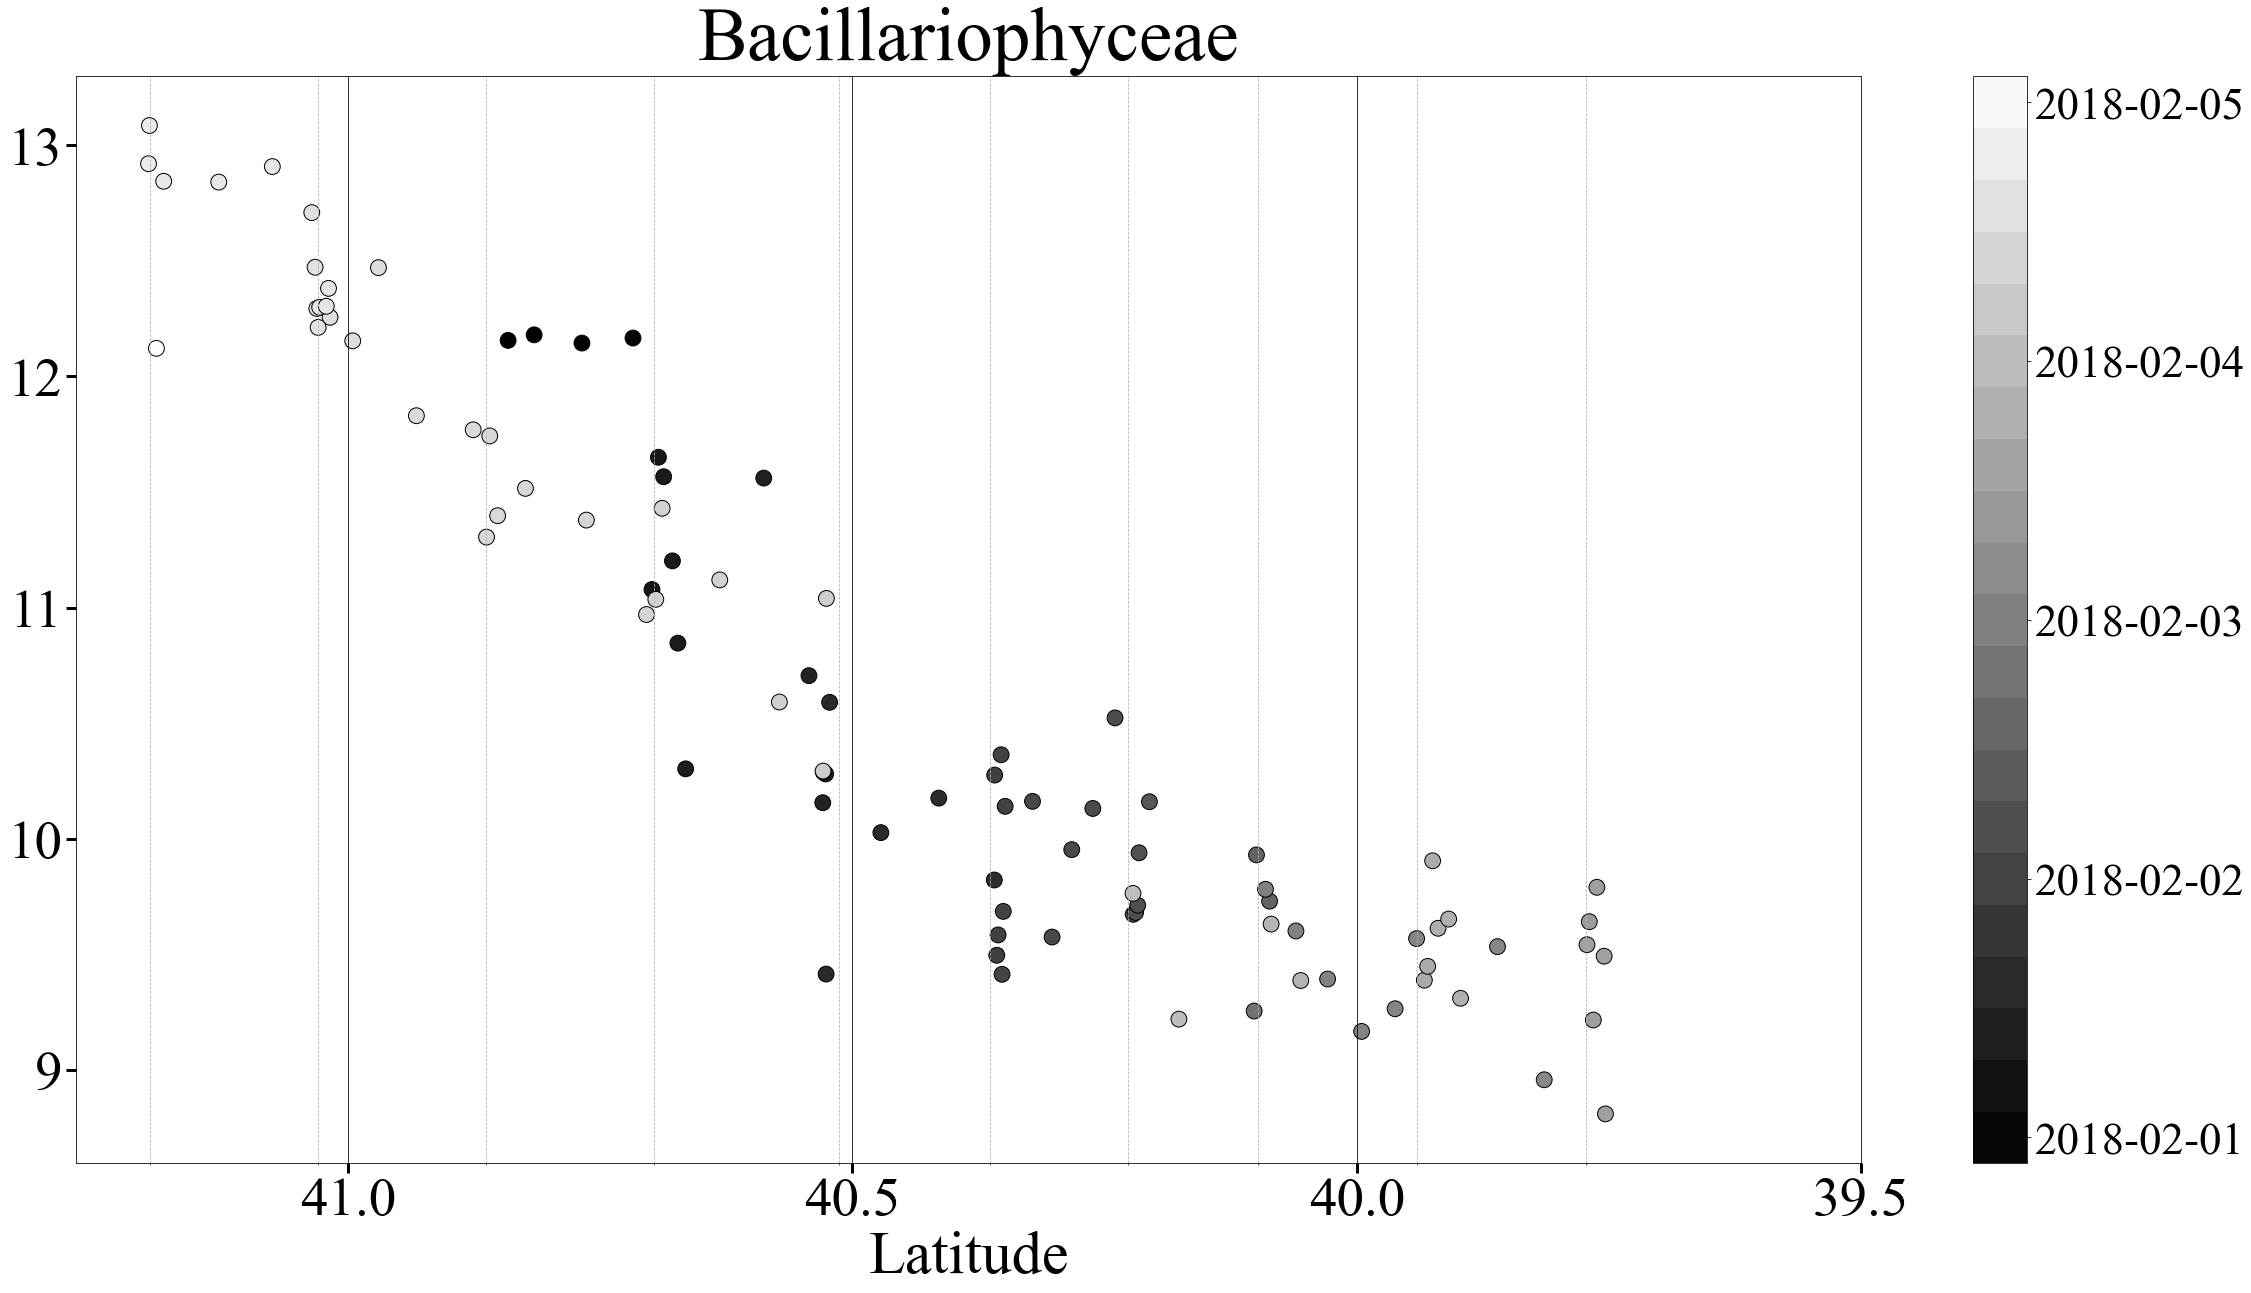

In [59]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(40, 20))
# use unstack()
if (dataset_type == 'both'): 
    rois = auto_samples.groupby(['gps_furuno_latitude','higherClassification_group_automated']).sum()['concentration']
    rois.unstack().plot(ax=ax, marker='o')
    rois = manual_samples.groupby(['gps_furuno_latitude','higherClassification_group_manual']).sum()['concentration']
    rois.unstack().plot(ax=ax, marker='o')
    L=plt.legend(title=None, prop={"size":20, "family": "Times New Roman"})
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    grouped = sample_subset.groupby(['gps_furuno_latitude','higherClassification_group_{}'.format(dataset_type)]).sum()['concentration']
#     rois.unstack().reset_index().plot.scatter(x='gps_furuno_latitude', y='Bacillariophyceae', 
#                                               ax=ax, marker='o', c=sample_subset.date, 
#                                              cmap='viridis', s=100).grid(axis='x')
    sample_subset.plot.scatter(x='gps_furuno_latitude', y='log_concentration', 
                          ax=ax, marker='o', c=sample_subset.date, 
                          cmap='gray', edgecolors='black', s=250).grid(axis='x')

    # set color bar
    sm = plt.cm.ScalarMappable(cmap='gray')
    sm.set_array([])
    cb = plt.colorbar(sm, ticks=np.linspace(0,2,5), 
             boundaries=np.arange(-0.05,2.1,.1))
    # stupid stupid color bar, sort indices first
    indices = [sample_subset.date[i] for i in np.linspace(0,grouped.shape[0]-1,5).astype(int)]
    cb.ax.set_yticklabels([index.strftime('%Y-%m-%d') for index in indices])
    cb.ax.tick_params(labelsize=45)
    # set stupid font
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

# add titles and axes labels
plt.xlabel('Latitude', size = 60, fontname="Times New Roman")
plt.ylabel('')
#plt.ylabel('Biovolume in targets with Max Feret Diameter > {} micrometers'.format(threshold), size = 25, fontname="Times New Roman")
plt.title(analysis_type, size = 75, fontname="Times New Roman")
# set stations as tick marks, separate into secondary xticks with labels
labels=[41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.0983, 39.94, 39.7733]
#labels=[41.2, 41.0, 40.9, 40.7, 40.5, 40.4, 40.2, 40.1, 39.9, 39.8]
ax.set_xticks(np.arange(39.5, 41.5,0.5))
# invert x axis
ax.invert_xaxis()

# set x minor axis for grids
minor_locator = FixedLocator(labels)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor', linestyle='--')
plt.grid(which='major', linestyle='-', color='black', axis='x')

# set fixed ylim max
#plt.gca().set_ylim(top=5)
plt.yticks(np.arange(np.rint(np.min(sample_subset['log_concentration'])), np.rint(np.max(sample_subset['log_concentration']))+0.5, 1))

ax.legend(title=None, prop={"size":35, "family": "Times New Roman"})
ax.get_legend().remove()
# plt.rcParams["font.family"] = "Times New Roman"
ax.tick_params(axis='both', which='major', labelsize=25, width=3, length=10)
# set tick marks font
for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(55)
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
    tick.set_fontsize(55)
fig = plt.gcf()
plt.show()

In [60]:
# Ask user if want to save graphs
while (True):
    reply = str(input('Save output? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        #fig1.savefig('percent_biovolume.png', bbox_inches='tight')
        fig.savefig(f'{analysis_type}_{param}_{sign}_{threshold}_biovolume.png', bbox_inches='tight')
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Save output? (y/n): y
